# Notebook to plot persistence from a dataframe produced by Pers_in_visit


In [1]:
from astropy.io import fits
import glob, os, shutil, pickle, bz2, gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sigmaclip
from scipy.optimize import curve_fit
from scipy.special import gammaincc, gamma
from astropy.wcs import WCS
from astropy.stats import histogram
from itertools import product
from multiprocessing import Pool

%matplotlib notebook

In [2]:
pwd

'/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence/Pixel_based'

In [3]:
# The project dir 
pdir = '/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence/'

#The mosaic dir
mdir = pdir+'/Mosaic_hi_res_folder/'

#The dir to save/load the Persistence curves dataframes
sdir = pdir+'/PD_dataframes_dir/'


In [4]:
#Single and double exponential models to be fitted to the data

def decay1(t,a1,t1):
    e1 = a1*np.exp(-t/t1)
    return e1

def intdec1(t,a1,t1):
    tu = t[1:]
    td = t[:-1]
    k  = -a1*t1
    return k*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td)
    
def decay2(t,a1,t1,a2,t2):
    e1 = a1*np.exp(-t/t1)
    e2 = a2*np.exp(-t/t2)
    return e1+e2

def intdec2(t,a1,t1,a2,t2):
    tu = t[1:]
    td = t[:-1]
    k1,k2  = -a1*t1, - a2*t2
    
    return k1*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td) + k2*(np.exp(-tu/t2)-np.exp(-td/t2))/(tu-td)

#Single exponential models plus a constant

def intdec1_plusconst(t,a1,t1,q):
    tu = t[1:]
    td = t[:-1]
    k  = -a1*t1
    return k*(np.exp(-tu/t1)-np.exp(-td/t1))/(tu-td) +q

def dec1_plusconst(t,a1,t1,q):
    e1 = a1*np.exp(-t/t1)
    return e1+q


#Shifted power law model

def shpwl(t,t0,A,index):
    return A * ((t+t0)/1000)**index

def intshpwl(t,t0,A,index):
    tu = t[1:]
    td = t[:-1]

    if (index == -1.):
        return A*np.log( (tu+t0)/(td+t0) )
    else:
        return A/(1+index) * ( ((tu+t0)/1000)**(1+index) - ((td+t0)/1000)**(1+index) )/(tu-td)
    
    
#Schechter like model

def schechter(t,phi,alpha,tstar):
    x = t/tstar
    return phi*(x**alpha)*np.exp(-x)

def intschechter(t,phi,alpha,tstar):
    x = t/tstar

    tu = x[1:]
    td = x[:-1]

    g1 = gammaincc(alpha+1,td)
    g2 = gammaincc(alpha+1,tu)
    
    diff = gamma(alpha+1)*(g1-g2)
    
    return phi*diff


#Geometric median calculation function

from scipy.spatial.distance import cdist, euclidean

def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1, D

        y = y1



In [5]:
#Cell to restore the hf5 store with the dataframe for each visit
#df = pd.DataFrame()

df = pd.DataFrame()
store = pd.HDFStore(sdir+'Test_DF.h5.bz2')

for i,k in enumerate(store.keys()):
    dfh = store.get(k)
    print('Number of entries for Visit ',i+1,':',len(dfh))
    dfh['Visit'] = i+1
    df = df.append(dfh)

Number of entries for Visit  1 : 8520408
Number of entries for Visit  2 : 11146325
Number of entries for Visit  3 : 15337113


In [6]:
print('Total number of entries',len(df))
df.head()

Total number of entries 35003846


,Stim,EXPTIME_stim,xpix,ypix,tfromstim,deltat,Read index,NSAMP,meancurr,stdvcurr,background,Ind_stim,Ind_pers,Stim_type,Pers_type,Visit
0,199470.589981,352.960416,551,0,418.987126,25.00051,15,16,8.340665,3.676377,9.326913,0,1,EXT,EXT,1
1,199470.589981,352.960416,551,0,393.986616,25.00052,14,16,9.200697,3.565107,9.326913,0,1,EXT,EXT,1
2,199470.589981,352.960416,551,0,368.986096,25.00052,13,16,7.929576,3.455253,9.326913,0,1,EXT,EXT,1
3,199470.589981,352.960416,551,0,343.985576,25.00052,12,16,8.838752,3.343626,9.326913,0,1,EXT,EXT,1
4,199470.589981,352.960416,551,0,318.985056,25.00052,11,16,12.070834,3.199562,9.326913,0,1,EXT,EXT,1


<IPython.core.display.Javascript object>


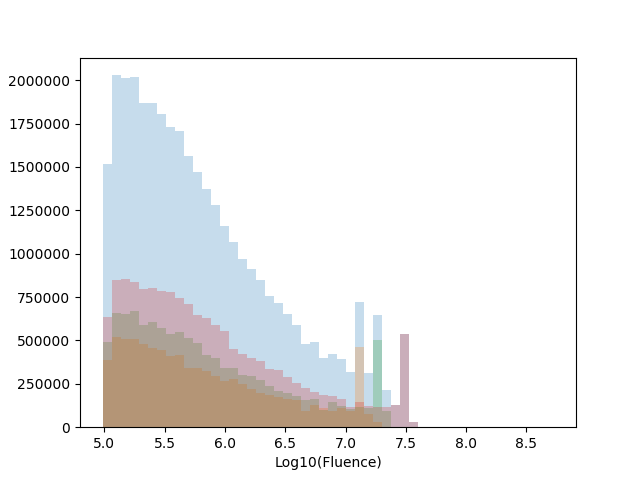

In [7]:
fig = plt.figure()

n,b,p = plt.hist(np.log10(df['Stim']),alpha=0.25,bins=50)
for vv in [1,2,3]:
    plt.hist(np.log10(df[df['Visit'] == vv]['Stim']),alpha=0.25,bins=b)
plt.xlabel('Log10(Fluence)')


In [14]:
#The stimulus levels probed

print('Minimum stimulus:',np.log10(np.min(df['Stim'].values)))
print('Maximum stimulus:',np.log10(np.max(df['Stim'].values)))


Minimum stimulus: 4.98378408178
Maximum stimulus: 8.72563878533


In [ ]:
#This cell is intended only for speeding up use

#df = df[np.log10(df['Stim']) > 6.5]


In [10]:
BM_rng25  = (df['deltat'] < 26) & (df['deltat'] > 24) 
BM_rng100  = (df['deltat'] < 101) & (df['deltat'] > 99) 
BM_pext = df['Pers_type'] =='EXT'
BM_V1   = df['Visit'] == 1
BM_V2   = df['Visit'] == 2
BM_V3   = df['Visit'] == 3

In [99]:
#levels = [5.0,5.1,5.5,5.75,6.,6.25,6.5,6.75,7.,7.25,7.5,7.75]
#levels = [6.75,7.,7.25]
levels = list(np.arange(4.85,7.9,0.35))

mean_res = {'levels': levels, 
            'med_times':[],
            'med_pers':[],
            'Npoints':[],
            'Readme': ['ALL',
                      # 'dT~25s',
                      # 'dT~25s & Ptyp == EXT',
                      # 'dT~25s & Ptyp != EXT',
                      # 'dT~25s & Ptyp == EXT & Vis == 1',
                      # 'dT~25s & Ptyp == EXT & Vis == 2',
                      # 'dT~25s & Ptyp == EXT & Vis == 3',
                      # 'dT~25s & Ptyp != EXT & Vis == 1',
                      # 'dT~25s & Ptyp != EXT & Vis == 2',
                      # 'dT~25s & Ptyp != EXT & Vis == 3',
                       'Visit 1',
                       'Visit 2',
                       'Visit 3',
                      # 'Ptyp == EXT & Vis == 1',
                      # 'Ptyp == EXT & Vis == 2',
                      # 'Ptyp == EXT & Vis == 3',
                      # 'Ptyp != EXT & Vis == 1',
                      # 'Ptyp != EXT & Vis == 2',
                      # 'Ptyp != EXT & Vis == 3',
                      # 'dT~100s',
                      # 'dT~100s & Ptyp == EXT',
                      # 'dT~100s & Ptyp != EXT',
                      # 'dT~100s & Ptyp == EXT & Vis == 1',
                      # 'dT~100s & Ptyp == EXT & Vis == 2',
                      # 'dT~100s & Ptyp == EXT & Vis == 3',
                      # 'dT~100s & Ptyp != EXT & Vis == 1',
                      # 'dT~100s & Ptyp != EXT & Vis == 2',
                      # 'dT~100s & Ptyp != EXT & Vis == 3',
                       
                      ]
            }    


step = 25.
    
for lev_dw,lev_up in zip(mean_res['levels'][0:-1],mean_res['levels'][1:]):
    
    print(lev_dw,lev_up)
    BM_lv = ( np.log10(df['Stim'].values) >= lev_dw ) & ( np.log10(df['Stim'].values) < lev_up )
    gBMs    =   [BM_lv]
#    gBMs.append(BM_lv & BM_rng25)
#    gBMs.append(BM_lv & BM_rng25 & BM_pext)
#    gBMs.append(BM_lv & BM_rng25 & (~BM_pext) )
#    gBMs.append(BM_lv & BM_rng25 & BM_pext & BM_V1)
#    gBMs.append(BM_lv & BM_rng25 & BM_pext & BM_V2)
#    gBMs.append(BM_lv & BM_rng25 & BM_pext & BM_V3)
#    gBMs.append(BM_lv & BM_rng25 & (~BM_pext) & BM_V1)
#    gBMs.append(BM_lv & BM_rng25 & (~BM_pext) & BM_V2)
#    gBMs.append(BM_lv & BM_rng25 & (~BM_pext) & BM_V3)
    gBMs.append(BM_lv & BM_V1)
    gBMs.append(BM_lv & BM_V2)
    gBMs.append(BM_lv & BM_V3)
#    gBMs.append(BM_lv & BM_pext & BM_V1)
#    gBMs.append(BM_lv & BM_pext & BM_V2)
#    gBMs.append(BM_lv & BM_pext & BM_V3)
#    gBMs.append(BM_lv & (~BM_pext) & BM_V1)
#    gBMs.append(BM_lv & (~BM_pext) & BM_V2)
#    gBMs.append(BM_lv & (~BM_pext) & BM_V3)
#    gBMs.append(BM_lv & BM_rng100)
#    gBMs.append(BM_lv & BM_rng100 & BM_pext)
#    gBMs.append(BM_lv & BM_rng100 & (~BM_pext) )
#    gBMs.append(BM_lv & BM_rng100 & BM_pext & BM_V1)
#    gBMs.append(BM_lv & BM_rng100 & BM_pext & BM_V2)
#    gBMs.append(BM_lv & BM_rng100 & BM_pext & BM_V3)
#    gBMs.append(BM_lv & BM_rng100 & (~BM_pext) & BM_V1)
#    gBMs.append(BM_lv & BM_rng100 & (~BM_pext) & BM_V2)
#    gBMs.append(BM_lv & BM_rng100 & (~BM_pext) & BM_V3)

    
    mth = []
    mph = []
    nph = []
    
    for i,gBM in enumerate(gBMs):
        print(mean_res['Readme'][i],np.sum(gBM),np.sum(BM_lv))
        
   #     df2 = df[['tfromstim','meancurr','background']][gBM]
        tmed   = []
        medsig = []
        npts   = []
        
        if (np.sum(gBM) > 0 ):
            df2 = df[gBM]
            tmin = np.min(df2['tfromstim'].values)
            tmax = np.max(df2['tfromstim'].values)

            while tmin <= tmax:

                BM =  (df2['tfromstim'].values > tmin-step/2.) & (df2['tfromstim'].values <= (tmin+ step/2.))
                tmin += step
                nn = np.sum(BM)
                if (nn > 5):
                    medsig.append(np.nanmedian(df2['meancurr'][BM].values-df2['background'][BM].values))
                    tmed.append(np.median(df2['tfromstim'][BM].values))
                    npts.append(nn)
    
        mth.append(tmed)
        mph.append(medsig)
        nph.append(npts)
        
    mean_res['med_times'].append(mth)
    mean_res['med_pers'].append(mph)
    mean_res['Npoints'].append(nph)
    

4.85 5.2
ALL 5343489 5343489
Visit 1 1360059 5343489
Visit 2 1733714 5343489
Visit 3 2249716 5343489
5.2 5.55
ALL 8750809 8750809
Visit 1 2178495 8750809
Visit 2 2831749 8750809
Visit 3 3740565 8750809
5.55 5.9
ALL 7185418 7185418
Visit 1 1681968 7185418
Visit 2 2270792 7185418
Visit 3 3232658 7185418
5.9 6.25
ALL 5002830 5002830
Visit 1 1201707 5002830
Visit 2 1566194 5002830
Visit 3 2234929 5002830
6.25 6.6
ALL 3414192 3414192
Visit 1 838419 3414192
Visit 2 1055211 3414192
Visit 3 1520562 3414192
6.6 6.95
ALL 2121761 2121761
Visit 1 516861 2121761
Visit 2 671471 2121761
Visit 3 933429 2121761
6.95 7.3
ALL 2258578 2258578
Visit 1 740292 2258578
Visit 2 910605 2258578
Visit 3 607681 2258578
7.3 7.65
ALL 926295 926295
Visit 1 2607 926295
Visit 2 106589 926295
Visit 3 817099 926295


<IPython.core.display.Javascript object>


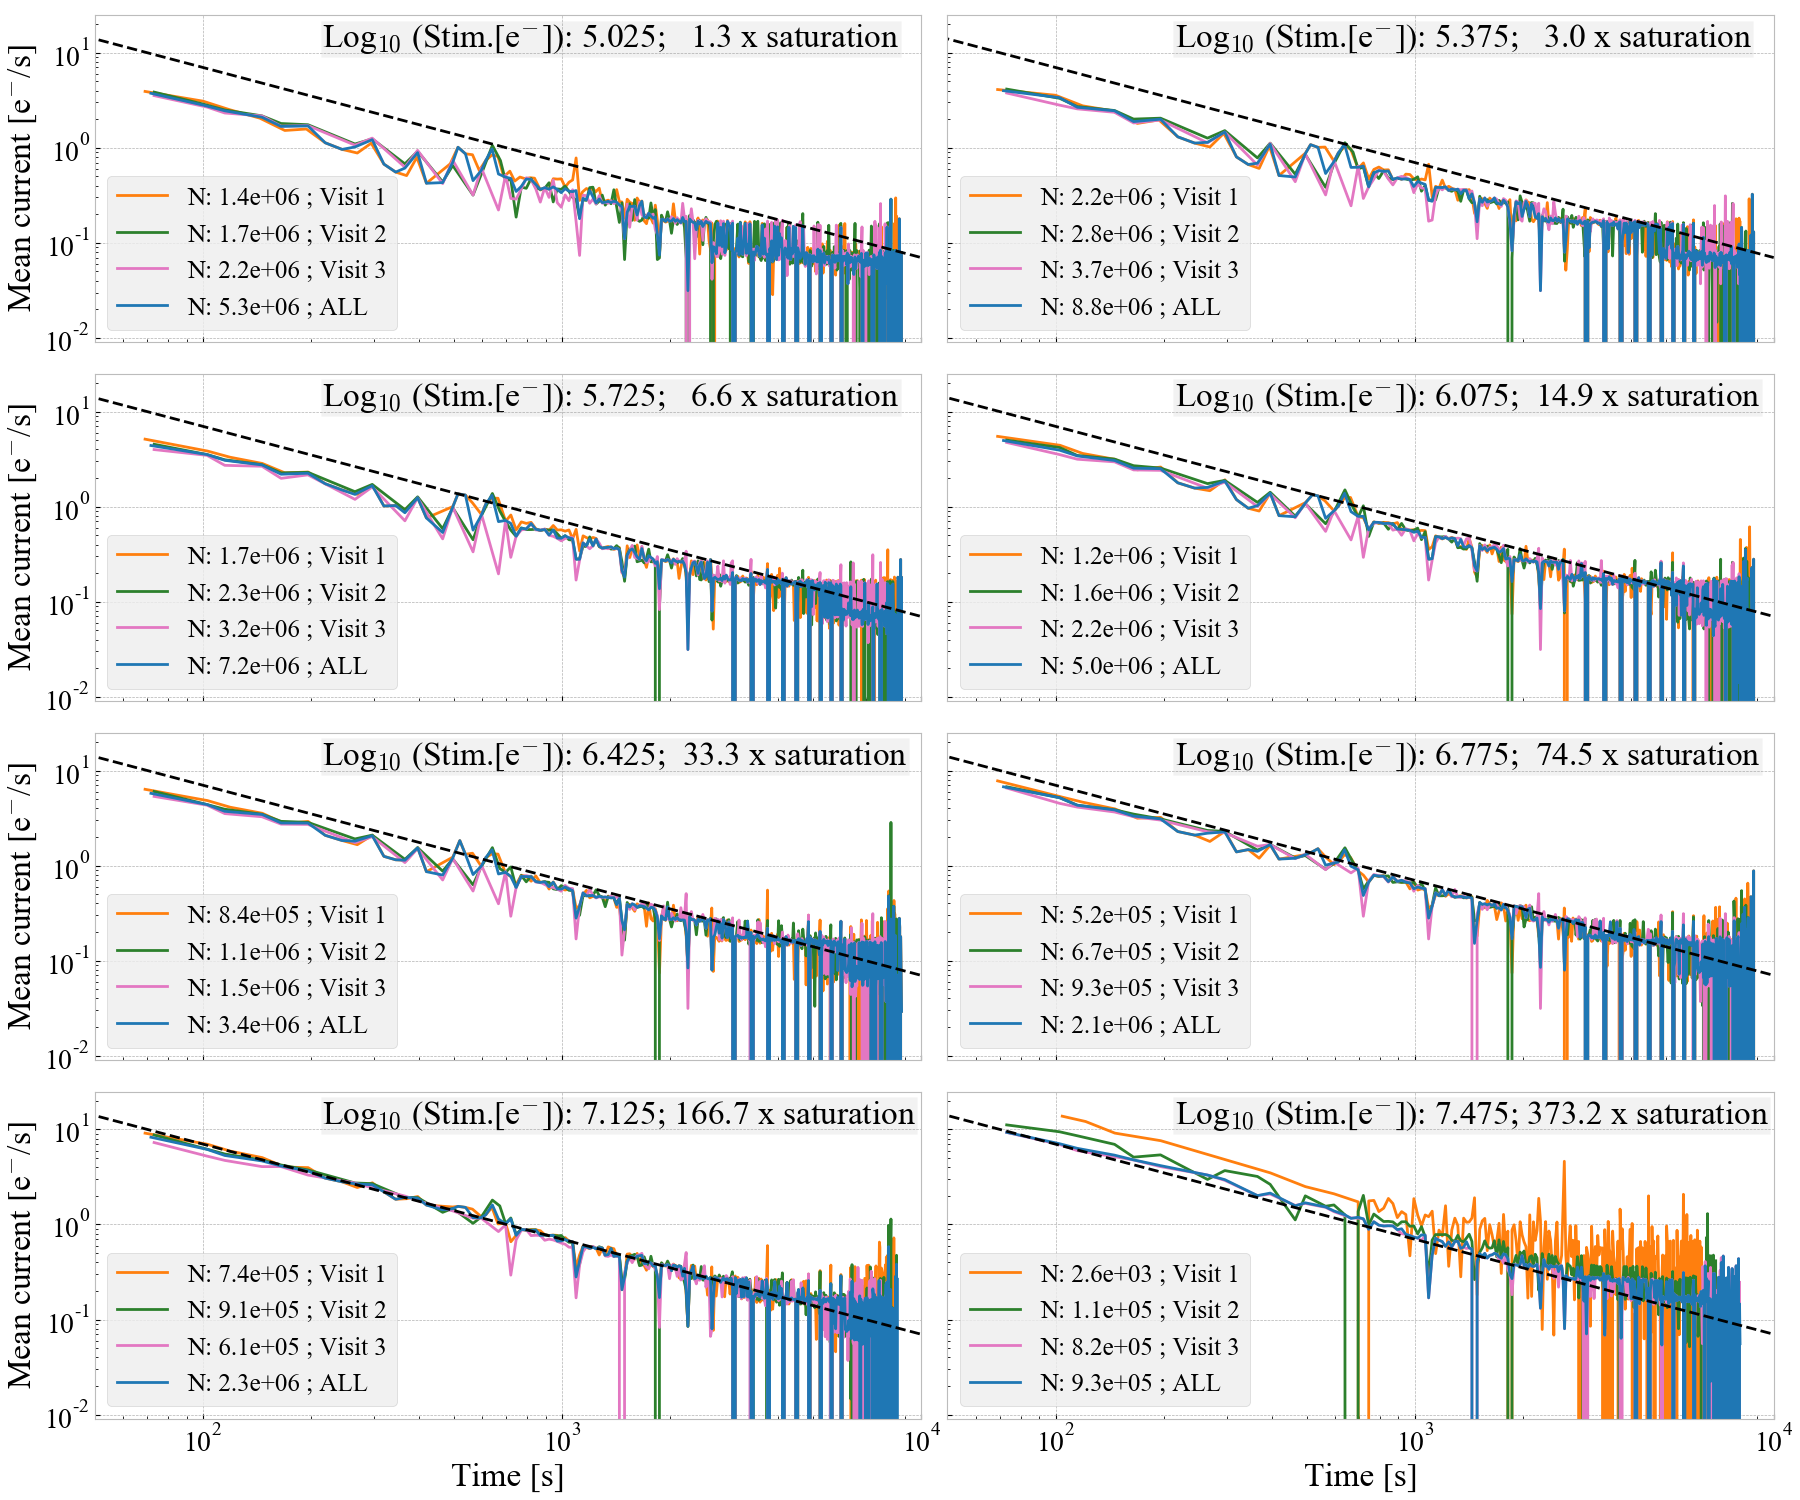

/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [130]:
#fig = plt.figure(figsize=(18,3*(len(mean_res['levels'])-1)))
ax = []

plt.style.use('bmh')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 24
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 16

fig, ax = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(18,15))

for i,(lev_dw,lev_up) in enumerate(zip(mean_res['levels'][0:-1],mean_res['levels'][1:])):

#    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,i+1))
    
    l = i//2
    k = i%2
    
    for j in [1,2,3,0]:
        ax[l,k].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],color=['#1f77b4','#ff7f0e','#2c802c','#e377c2'][j],
                     label='N: '+'{:3.1e}'.format(1.*np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])
    ax[l,k].set_xscale('log')
    ax[l,k].set_yscale('log')
    meanlev = 0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])
    titlestring = 'Log$_{10}$ (Stim.[e$^{-}$]): ' + '{:5.3f}'.format(meanlev) + '; ' + '{:5.1f}'.format(10**meanlev/80000.) +' x saturation' 
#    ax[l,k].set_title(titlestring,fontsize=10)
    ax[l,k].text(0.275,0.875,titlestring,verticalalignment='bottom', horizontalalignment='left',transform=ax[l,k].transAxes,bbox={'facecolor':'gray', 'alpha':.1, 'pad':1},fontsize=24)

    ax[l,k].legend(fontsize=18,loc=3)
    
    ax[l,k].set_ylim(0.009,25)
    ax[l,k].set_xlim(50,10000)
    
    ax[l,k].plot(np.array([1,10000]),700*np.array([1,1/10000.]),'--',c='black')

    if l==3:
        ax[l,k].set_xlabel('Time [s]',fontsize=24)
    if k==0:
        ax[l,k].set_ylabel('Mean current [e$^{-}$/s]',fontsize=24)
    ax[l,k].set_axis_bgcolor('#FFFFFF')
    
plt.tight_layout(pad=.2)

plt.savefig('/Users/gennaro/Congressi_Seminari/SDW_2017/Pdecay.pdf',format='pdf')


In [ ]:
fig = plt.figure(figsize=(18,3*(len(mean_res['levels'])-1)))
ax = []
for i,(lev_dw,lev_up) in enumerate(zip(mean_res['levels'][0:-1],mean_res['levels'][1:])):

    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,2*i+1))
    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,2*i+2))
    
    for j in range(len(mean_res['Readme'][0:4])):
        ax[-2].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])
        ax[-1].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])

    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_title('Log10(Stim): '+ str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
    ax[-2].set_title('Log10(Stim): '+ str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
    ax[-1].legend(fontsize=11)
    ax[-2].legend(fontsize=11)
    
    ax[-1].set_ylim(0.001,15)
    ax[-2].set_ylim(-2,15)
    ax[-1].set_xlim(50,10000)
    ax[-2].set_xlim(50,10000)
    
    ax[-1].plot(np.array([1,10000]),700*np.array([1,1/10000.]),'--',c='black')
    
    ax[-2].set_xlabel('Time [s]')
    ax[-1].set_xlabel('Time [s]')
    ax[-2].set_ylabel('Mean current [e-/s]')
    ax[-1].set_ylabel('Mean current [e-/s]')

    
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(18,3*(len(mean_res['levels'])-1)))
ax = []
for i,(lev_dw,lev_up) in enumerate(zip(mean_res['levels'][0:-1],mean_res['levels'][1:])):

    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,2*i+1))
    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,2*i+2))

    for k in range(len(mean_res['Readme'][4:7])):
        j = k+4
        ax[-2].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])
        ax[-1].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])

    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_title('Log10(Stim): '+ str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
    ax[-2].set_title('Log10(Stim): '+ str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
    ax[-1].legend(fontsize=11)
    ax[-2].legend(fontsize=11)
    
    ax[-1].set_ylim(0.001,15)
    ax[-2].set_ylim(-2,15)
    ax[-1].set_xlim(50,10000)
    ax[-2].set_xlim(50,10000)

    ax[-1].plot(np.array([1,10000]),700*np.array([1,1/10000.]),'--',c='black')

    ax[-2].set_xlabel('Time [s]')
    ax[-1].set_xlabel('Time [s]')
    ax[-2].set_ylabel('Mean current [e-/s]')
    ax[-1].set_ylabel('Mean current [e-/s]')

    
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(18,3*(len(mean_res['levels'])-1)))
ax = []
for i,(lev_dw,lev_up) in enumerate(zip(mean_res['levels'][0:-1],mean_res['levels'][1:])):

    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,2*i+1))
    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,2*i+2))

    for k in range(len(mean_res['Readme'][7:10])):
        j = k+7
        ax[-2].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])
        ax[-1].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])

    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_title('Log10(Stim): '+ str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
    ax[-2].set_title('Log10(Stim): '+ str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
    ax[-1].legend(fontsize=11)
    ax[-2].legend(fontsize=11)
    
    ax[-1].set_ylim(0.001,15)
    ax[-2].set_ylim(-2,15)
    ax[-1].set_xlim(50,10000)
    ax[-2].set_xlim(50,10000)

    ax[-1].plot(np.array([1,10000]),700*np.array([1,1/10000.]),'--',c='black')

    ax[-2].set_xlabel('Time [s]')
    ax[-1].set_xlabel('Time [s]')
    ax[-2].set_ylabel('Mean current [e-/s]')
    ax[-1].set_ylabel('Mean current [e-/s]')

    
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(18,3*(len(mean_res['levels'])-1)))
ax = []
for i,(lev_dw,lev_up) in enumerate(zip(mean_res['levels'][0:-1],mean_res['levels'][1:])):

    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,2*i+1))
    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,2*i+2))

    for k in range(len(mean_res['Readme'][10:13])):
        j = k+10
        ax[-2].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])
        ax[-1].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])

    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_title('Log10(Stim): '+ str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
    ax[-2].set_title('Log10(Stim): '+ str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
    ax[-1].legend(fontsize=11)
    ax[-2].legend(fontsize=11)
    
    ax[-1].set_ylim(0.001,15)
    ax[-2].set_ylim(-2,15)
    ax[-1].set_xlim(50,10000)
    ax[-2].set_xlim(50,10000)

    ax[-1].plot(np.array([1,10000]),700*np.array([1,1/10000.]),'--',c='black')

    ax[-2].set_xlabel('Time [s]')
    ax[-1].set_xlabel('Time [s]')
    ax[-2].set_ylabel('Mean current [e-/s]')
    ax[-1].set_ylabel('Mean current [e-/s]')

    
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(18,3*(len(mean_res['levels'])-1)))
ax = []
for i,(lev_dw,lev_up) in enumerate(zip(mean_res['levels'][0:-1],mean_res['levels'][1:])):

    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,2*i+1))
    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,2*i+2))

    for k in range(len(mean_res['Readme'][13:16])):
        j = k+13
        ax[-2].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])
        ax[-1].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])

    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_title('Log10(Stim): '+ str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
    ax[-2].set_title('Log10(Stim): '+ str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
    ax[-1].legend(fontsize=11)
    ax[-2].legend(fontsize=11)
    
    ax[-1].set_ylim(0.001,15)
    ax[-2].set_ylim(-2,15)
    ax[-1].set_xlim(50,10000)
    ax[-2].set_xlim(50,10000)

    ax[-1].plot(np.array([1,10000]),700*np.array([1,1/10000.]),'--',c='black')

    ax[-2].set_xlabel('Time [s]')
    ax[-1].set_xlabel('Time [s]')
    ax[-2].set_ylabel('Mean current [e-/s]')
    ax[-1].set_ylabel('Mean current [e-/s]')

    
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(18,3*(len(mean_res['levels'])-1)))
ax = []
for i,(lev_dw,lev_up) in enumerate(zip(mean_res['levels'][0:-1],mean_res['levels'][1:])):

    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,2*i+1))
    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,2*i+2))

    for k in range(len(mean_res['Readme'][16:19])):
        j = k+16
        ax[-2].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])
        ax[-1].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])

    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_title('Log10(Stim): '+ str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
    ax[-2].set_title('Log10(Stim): '+ str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
    ax[-1].legend(fontsize=11)
    ax[-2].legend(fontsize=11)
    
    ax[-1].set_ylim(0.001,15)
    ax[-2].set_ylim(-2,15)
    ax[-1].set_xlim(50,10000)
    ax[-2].set_xlim(50,10000)

    ax[-1].plot(np.array([1,10000]),700*np.array([1,1/10000.]),'--',c='black')

    ax[-2].set_xlabel('Time [s]')
    ax[-1].set_xlabel('Time [s]')
    ax[-2].set_ylabel('Mean current [e-/s]')
    ax[-1].set_ylabel('Mean current [e-/s]')

    
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(18,3*(len(mean_res['levels'])-1)))
ax = []
for i,(lev_dw,lev_up) in enumerate(zip(mean_res['levels'][0:-1],mean_res['levels'][1:])):

    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,2*i+1))
    ax.append(fig.add_subplot(len(mean_res['levels'])-1,2,2*i+2))

    for k in range(len(mean_res['Readme'][19:22])):
        j = k+19
        ax[-2].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])
        ax[-1].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; '+mean_res['Readme'][j])

    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_title('Log10(Stim): '+ str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
    ax[-2].set_title('Log10(Stim): '+ str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
    ax[-1].legend(fontsize=11)
    ax[-2].legend(fontsize=11)
    
    ax[-1].set_ylim(0.001,15)
    ax[-2].set_ylim(-2,15)
    ax[-1].set_xlim(50,10000)
    ax[-2].set_xlim(50,10000)

    ax[-1].plot(np.array([1,10000]),700*np.array([1,1/10000.]),'--',c='black')

    ax[-2].set_xlabel('Time [s]')
    ax[-1].set_xlabel('Time [s]')
    ax[-2].set_ylabel('Mean current [e-/s]')
    ax[-1].set_ylabel('Mean current [e-/s]')

    
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(18,3*len(mean_res['Readme'][0:4])))
ax = []
for j,rm in enumerate(mean_res['Readme'][0:4]):

    ax.append(fig.add_subplot(len(mean_res['Readme'][0:4]),2,2*j+1))
    ax.append(fig.add_subplot(len(mean_res['Readme'][0:4]),2,2*j+2))
    
    for i in range(len(mean_res['levels'])-1):
        ax[-2].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; Log10(Stim): '+str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))
        ax[-1].plot(mean_res['med_times'][i][j],mean_res['med_pers'][i][j],label='N:'+str(np.sum(mean_res['Npoints'][i][j]))+' ; Log10(Stim): '+str(0.5*(mean_res['levels'][i]+mean_res['levels'][i+1])))

    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_title(mean_res['Readme'][j])
    ax[-2].set_title(mean_res['Readme'][j])
    ax[-1].legend(fontsize=11)
    ax[-2].legend(fontsize=11)
    
    ax[-1].set_ylim(0.001,15)
    ax[-2].set_ylim(-2,15)
    ax[-1].set_xlim(50,10000)
    ax[-2].set_xlim(50,10000)

    ax[-1].plot(np.array([1,10000]),700*np.array([1,1/10000.]),'--',c='black')

    ax[-2].set_xlabel('Time [s]')
    ax[-1].set_xlabel('Time [s]')
    ax[-2].set_ylabel('Mean current [e-/s]')
    ax[-1].set_ylabel('Mean current [e-/s]')

    
plt.tight_layout()

In [ ]:
gBMs    =   [np.log10(df['Stim']) > 7.25]
#gBMs.append( (df['Stim'] > 1e7) & (df['deltat'] < 26) & (df['deltat'] > 24)  )
#gBMs.append( (df['Stim'] < 1e7) & (df['deltat'] < 26) & (df['deltat'] > 24)  )
#gBMs.append( (df['Stim'] > 1e7) & (df['deltat'] < 26) & (df['deltat'] > 24) & (df['Pers_type'] =='EXT' ))
#gBMs.append( (df['Stim'] > 1e7) & (df['deltat'] < 26) & (df['deltat'] > 24) & (df['Pers_type'] !='EXT' ))
#gBMs.append( (df['Stim'] > 1e7) & (df['deltat'] < 26) & (df['deltat'] > 24) & (df['Pers_type'] !='EXT' ) & (df['Visit'] == 1 ))
#gBMs.append( (df['Stim'] > 1e7) & (df['deltat'] < 26) & (df['deltat'] > 24) & (df['Pers_type'] !='EXT' ) & (df['Visit'] == 2 ))
#gBMs.append( (df['Stim'] > 1e7) & (df['deltat'] < 26) & (df['deltat'] > 24) & (df['Pers_type'] !='EXT' ) & (df['Visit'] == 3 ))


fig = plt.figure(figsize=(15,4*len(gBMs)))
ax = []

for i,gBM in enumerate(gBMs):

#    df2 = df[gBM].copy()
#    df2 = df.copy()
    print(len(df2))
    
    ax.append(fig.add_subplot(len(gBMs),2,1+i*2))
    ax.append(fig.add_subplot(len(gBMs),2,2+i*2))
    
#    col = np.where(df['Pers_type'].values == 'DARK',np.repeat('#55adff',len(df2)),np.repeat('#12679B',len(df2)))
    
    ax[-2].scatter(df['tfromstim'][BM_V1 & gBM & BM_pext],df['meancurr'][BM_V1 & gBM & BM_pext]-df['background'][BM_V1 & gBM & BM_pext],s=3,alpha=0.6,c='#0922a0')
    ax[-1].scatter(df['tfromstim'][BM_V1 & gBM & BM_pext],df['meancurr'][BM_V1 & gBM & BM_pext]-df['background'][BM_V1 & gBM & BM_pext],s=3,alpha=0.6,c='#0922a0')
    ax[-2].scatter(df['tfromstim'][BM_V2 & gBM & BM_pext],df['meancurr'][BM_V2 & gBM & BM_pext]-df['background'][BM_V2 & gBM & BM_pext],s=3,alpha=0.6,c='#1b8406')
    ax[-1].scatter(df['tfromstim'][BM_V2 & gBM & BM_pext],df['meancurr'][BM_V2 & gBM & BM_pext]-df['background'][BM_V2 & gBM & BM_pext],s=3,alpha=0.6,c='#1b8406')
    ax[-2].scatter(df['tfromstim'][BM_V3 & gBM & BM_pext],df['meancurr'][BM_V3 & gBM & BM_pext]-df['background'][BM_V3 & gBM & BM_pext],s=3,alpha=0.6,c='#c11509')
    ax[-1].scatter(df['tfromstim'][BM_V3 & gBM & BM_pext],df['meancurr'][BM_V3 & gBM & BM_pext]-df['background'][BM_V3 & gBM & BM_pext],s=3,alpha=0.6,c='#c11509')

    ax[-2].scatter(df['tfromstim'][BM_V1 & gBM & ~BM_pext],df['meancurr'][BM_V1 & gBM & ~BM_pext]-df['background'][BM_V1 & gBM & ~BM_pext],s=3,alpha=0.6,c='#0b88ba')
    ax[-1].scatter(df['tfromstim'][BM_V1 & gBM & ~BM_pext],df['meancurr'][BM_V1 & gBM & ~BM_pext]-df['background'][BM_V1 & gBM & ~BM_pext],s=3,alpha=0.6,c='#0b88ba')
    ax[-2].scatter(df['tfromstim'][BM_V2 & gBM & ~BM_pext],df['meancurr'][BM_V2 & gBM & ~BM_pext]-df['background'][BM_V2 & gBM & ~BM_pext],s=3,alpha=0.6,c='#72dd5d')
    ax[-1].scatter(df['tfromstim'][BM_V2 & gBM & ~BM_pext],df['meancurr'][BM_V2 & gBM & ~BM_pext]-df['background'][BM_V2 & gBM & ~BM_pext],s=3,alpha=0.6,c='#72dd5d')
    ax[-2].scatter(df['tfromstim'][BM_V3 & gBM & ~BM_pext],df['meancurr'][BM_V3 & gBM & ~BM_pext]-df['background'][BM_V3 & gBM & ~BM_pext],s=3,alpha=0.6,c='#c66b7d')
    ax[-1].scatter(df['tfromstim'][BM_V3 & gBM & ~BM_pext],df['meancurr'][BM_V3 & gBM & ~BM_pext]-df['background'][BM_V3 & gBM & ~BM_pext],s=3,alpha=0.6,c='#c66b7d')

    step = 25.
    tmin = np.min(df2['tfromstim'].values)
    tmax = np.max(df2['tfromstim'].values)

    tmed   = []
    medsig = []

    while tmin <= tmax:

        BM =  (df2['tfromstim'].values > tmin-step/2.) & (df2['tfromstim'].values <= (tmin+ step/2.))
        tmin += step
        if (np.sum(BM) > 5):
            medsig.append(np.nanmedian(df2['meancurr'][BM].values-df2['background'][BM].values))
            tmed.append(np.median(df2['tfromstim'][BM].values))
    
            #gv = sigmaclip((df2['meancurr'][BM].values-df2['background'][BM].values),2.5,2.5)[0]
            #if (len(gv) >= 3):
                #medsig.append(np.nanmedian(gv))
                #tmed.append(np.median(df2['tfromstim'][BM].values))
    
    ax[-2].plot(tmed,medsig,c='r')
    ax[-1].plot(tmed,medsig,c='r')               
    ax[-1].plot(np.array([1,10000]),700*np.array([1.,1/10000.]),c='black')

    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_ylim(0.001,100)
    ax[-2].set_ylim(-20,100)
    ax[-1].set_xlim(50,10000)
    ax[-2].set_xlim(50,10000)
    
    ax[-2].set_xlabel('Time [s]')
    ax[-1].set_xlabel('Time [s]')
    ax[-2].set_ylabel('Mean current')
    ax[-1].set_ylabel('Mean current')

    
plt.tight_layout()

In [ ]:
gBMs    =   [np.log10(df['Stim']) > 7.25]
#gBMs.append( (df['Stim'] > 1e7) & (df['deltat'] < 26) & (df['deltat'] > 24)  )
#gBMs.append( (df['Stim'] < 1e7) & (df['deltat'] < 26) & (df['deltat'] > 24)  )
#gBMs.append( (df['Stim'] > 1e7) & (df['deltat'] < 26) & (df['deltat'] > 24) & (df['Pers_type'] =='EXT' ))
#gBMs.append( (df['Stim'] > 1e7) & (df['deltat'] < 26) & (df['deltat'] > 24) & (df['Pers_type'] !='EXT' ))
#gBMs.append( (df['Stim'] > 1e7) & (df['deltat'] < 26) & (df['deltat'] > 24) & (df['Pers_type'] !='EXT' ) & (df['Visit'] == 1 ))
#gBMs.append( (df['Stim'] > 1e7) & (df['deltat'] < 26) & (df['deltat'] > 24) & (df['Pers_type'] !='EXT' ) & (df['Visit'] == 2 ))
#gBMs.append( (df['Stim'] > 1e7) & (df['deltat'] < 26) & (df['deltat'] > 24) & (df['Pers_type'] !='EXT' ) & (df['Visit'] == 3 ))


fig = plt.figure(figsize=(15,4*len(gBMs)))
ax = []

for i,gBM in enumerate(gBMs):

#    df2 = df[gBM].copy()
#    df2 = df.copy()
    print(len(df2))
    
    ax.append(fig.add_subplot(len(gBMs),2,1+i*2))
    ax.append(fig.add_subplot(len(gBMs),2,2+i*2))
    
#    col = np.where(df['Pers_type'].values == 'DARK',np.repeat('#55adff',len(df2)),np.repeat('#12679B',len(df2)))
    
    ax[-2].scatter(df['tfromstim'][BM_V1 & gBM & BM_pext],df['meancurr'][BM_V1 & gBM & BM_pext]-df['background'][BM_V1 & gBM & BM_pext],s=7,alpha=0.8,c='#0922a0')
    ax[-1].scatter(df['tfromstim'][BM_V1 & gBM & BM_pext],df['meancurr'][BM_V1 & gBM & BM_pext]-df['background'][BM_V1 & gBM & BM_pext],s=7,alpha=0.8,c='#0922a0')
    ax[-2].scatter(df['tfromstim'][BM_V2 & gBM & BM_pext],df['meancurr'][BM_V2 & gBM & BM_pext]-df['background'][BM_V2 & gBM & BM_pext],s=7,alpha=0.8,c='#1b8406')
    ax[-1].scatter(df['tfromstim'][BM_V2 & gBM & BM_pext],df['meancurr'][BM_V2 & gBM & BM_pext]-df['background'][BM_V2 & gBM & BM_pext],s=7,alpha=0.8,c='#1b8406')
    ax[-2].scatter(df['tfromstim'][BM_V3 & gBM & BM_pext],df['meancurr'][BM_V3 & gBM & BM_pext]-df['background'][BM_V3 & gBM & BM_pext],s=7,alpha=0.8,c='#c11509')
    ax[-1].scatter(df['tfromstim'][BM_V3 & gBM & BM_pext],df['meancurr'][BM_V3 & gBM & BM_pext]-df['background'][BM_V3 & gBM & BM_pext],s=7,alpha=0.8,c='#c11509')

    ax[-2].scatter(df['tfromstim'][BM_V1 & gBM & ~BM_pext],df['meancurr'][BM_V1 & gBM & ~BM_pext]-df['background'][BM_V1 & gBM & ~BM_pext],s=7,alpha=0.8,c='#0b88ba')
    ax[-1].scatter(df['tfromstim'][BM_V1 & gBM & ~BM_pext],df['meancurr'][BM_V1 & gBM & ~BM_pext]-df['background'][BM_V1 & gBM & ~BM_pext],s=7,alpha=0.8,c='#0b88ba')
    ax[-2].scatter(df['tfromstim'][BM_V2 & gBM & ~BM_pext],df['meancurr'][BM_V2 & gBM & ~BM_pext]-df['background'][BM_V2 & gBM & ~BM_pext],s=7,alpha=0.8,c='#72dd5d')
    ax[-1].scatter(df['tfromstim'][BM_V2 & gBM & ~BM_pext],df['meancurr'][BM_V2 & gBM & ~BM_pext]-df['background'][BM_V2 & gBM & ~BM_pext],s=7,alpha=0.8,c='#72dd5d')
    ax[-2].scatter(df['tfromstim'][BM_V3 & gBM & ~BM_pext],df['meancurr'][BM_V3 & gBM & ~BM_pext]-df['background'][BM_V3 & gBM & ~BM_pext],s=7,alpha=0.8,c='#c66b7d')
    ax[-1].scatter(df['tfromstim'][BM_V3 & gBM & ~BM_pext],df['meancurr'][BM_V3 & gBM & ~BM_pext]-df['background'][BM_V3 & gBM & ~BM_pext],s=7,alpha=0.8,c='#c66b7d')

    step = 25.
    tmin = np.min(df2['tfromstim'].values)
    tmax = np.max(df2['tfromstim'].values)

    tmed   = []
    medsig = []

    while tmin <= tmax:

        BM =  (df2['tfromstim'].values > tmin-step/2.) & (df2['tfromstim'].values <= (tmin+ step/2.))
        tmin += step
        if (np.sum(BM) > 5):
            medsig.append(np.nanmedian(df2['meancurr'][BM].values-df2['background'][BM].values))
            tmed.append(np.median(df2['tfromstim'][BM].values))
    
            #gv = sigmaclip((df2['meancurr'][BM].values-df2['background'][BM].values),2.5,2.5)[0]
            #if (len(gv) >= 3):
                #medsig.append(np.nanmedian(gv))
                #tmed.append(np.median(df2['tfromstim'][BM].values))
    
    ax[-2].plot(tmed,medsig,c='r')
    ax[-1].plot(tmed,medsig,c='r')               
    ax[-1].plot(np.array([1,10000]),700*np.array([1.,1/10000.]),c='black')

    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_ylim(1,50)
    ax[-2].set_ylim(-30,50)
    ax[-1].set_xlim(85,130)
    ax[-2].set_xlim(85,130)
    
    ax[-2].set_xlabel('Time [s]')
    ax[-1].set_xlabel('Time [s]')
    ax[-2].set_ylabel('Mean current')
    ax[-1].set_ylabel('Mean current')

    
plt.tight_layout()

gstims = np.unique(df['Ind_stim'] )

fig = plt.figure(figsize=(15,4*gstims.size))

ax = []

for j,i in enumerate(gstims):
    gBMh = (df['Ind_stim'] == i) & (df['Ind_pers'] != 7) & (df['Read index'] != 1) &  (df['Ind_pers'] <7)
    
    if (np.sum(gBMh) > 0):
        df2 = df[gBMh]
        ax.append(fig.add_subplot(gstims.size,2,j*2+1))
        ax.append(fig.add_subplot(gstims.size,2,j*2+2))

        col = np.where(df2['Ind_pers']>=7,np.repeat('#55adff',len(df2)),np.repeat('#12679B',len(df2)))
        
        ax[-2].scatter(df2['tfromstim'],df2['meancurr']-df2['background'],s=2,alpha=0.7,c=col)
        ax[-1].scatter(df2['tfromstim'],df2['meancurr']-df2['background'],s=2,alpha=0.7,c=col)

        tmedh = []
        medsigh= []
        
        step = 25
        tmin = np.min(df2['tfromstim'].values)
        tmax = np.max(df2['tfromstim'].values)

        while tmin <= tmax:
    
            BM =  (df2['tfromstim'].values > tmin-step/2.) & (df2['tfromstim'].values <= (tmin+ step/2.))
            tmin += step
            if (np.sum(BM) > 5):
                tmedh.append(np.median(df2[BM]['tfromstim']))
                #medsigh.append(np.nanmedian(sigmaclip((df2[BM]['meancurr'].values-df2[BM]['background'].values),2.5,2.5)[0]))
                medsigh.append(np.nanmedian(df2[BM]['meancurr'].values-df2[BM]['background']))
    
        ax[-2].plot(tmed,medsig,c='r')
        ax[-1].plot(tmed,medsig,c='r')
        ax[-2].plot(tmedh,medsigh,c='orange')
        ax[-1].plot(tmedh,medsigh,c='orange')
    else:
        ax[-2].plot(tmed,medsig,c='r')
        ax[-1].plot(tmed,medsig,c='r')
 
    ax[-1].plot(np.array([1,10000]),700*np.array([1,1/10000.]),c='black')
    
    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_ylim(0.001,100)
    ax[-2].set_ylim(-10,100)
    ax[-1].set_xlim(1,10000)
    ax[-2].set_xlim(1,10000)

plt.tight_layout()

gstims = np.unique(df['Ind_stim'] )

fig = plt.figure(figsize=(15,4*gstims.size))

ax = []

for j,i in enumerate(gstims):
    gBMh = (df['Ind_stim'] == i) & (df['Ind_pers'] != 7) & (df['Read index'] != 1) &  (df['Ind_pers'] >7)
    
    if (np.sum(gBMh) > 0):
        df2 = df[gBMh]
        ax.append(fig.add_subplot(gstims.size,2,j*2+1))
        ax.append(fig.add_subplot(gstims.size,2,j*2+2))

        col = np.where(df2['Ind_pers']>=7,np.repeat('#55adff',len(df2)),np.repeat('#12679B',len(df2)))
        
        ax[-2].scatter(df2['tfromstim'],df2['meancurr']-df2['background'],s=2,alpha=0.7,c=col)
        ax[-1].scatter(df2['tfromstim'],df2['meancurr']-df2['background'],s=2,alpha=0.7,c=col)

        tmedh = []
        medsigh= []
        
        step = 25
        tmin = np.min(df2['tfromstim'].values)
        tmax = np.max(df2['tfromstim'].values)

        while tmin <= tmax:
    
            BM =  (df2['tfromstim'].values > tmin-step/2.) & (df2['tfromstim'].values <= (tmin+ step/2.))
            tmin += step
            if (np.sum(BM) > 5):
                tmedh.append(np.median(df2[BM]['tfromstim']))
                #medsigh.append(np.nanmedian(sigmaclip((df2[BM]['meancurr'].values-df2[BM]['background'].values),2.5,2.5)[0]))
                medsigh.append(np.nanmedian(df2[BM]['meancurr'].values-df2[BM]['background']))
    
        ax[-2].plot(tmed,medsig,c='r')
        ax[-1].plot(tmed,medsig,c='r')
        ax[-2].plot(tmedh,medsigh,c='orange')
        ax[-1].plot(tmedh,medsigh,c='orange')
    else:
        ax[-2].plot(tmed,medsig,c='r')
        ax[-1].plot(tmed,medsig,c='r')
  
    ax[-1].plot(np.array([1,10000]),700*np.array([1,1/10000.]),c='black')
    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_ylim(0.001,100)
    ax[-2].set_ylim(-10,100)
    ax[-1].set_xlim(1,10000)
    ax[-2].set_xlim(1,10000)

plt.tight_layout()

mf=1.2
levels = lev_d * np.array([1,np.power(mf,1),np.power(mf,2),np.power(mf,3),np.power(mf,4),np.power(mf,5),np.power(mf,6),np.power(mf,7)])

fig = plt.figure(figsize=(15,4*levels.size))

ax = []

colors = np.array(['#e41a1c', '#377eb8', '#4daf4a','#a44a7c','#123321','#cad111','#111cad','#abccdb','#dd88a1','#ab0011',
                   '#aa11ca','#b18522','#097023','#909090','#090909','#FDEEDF','DDDDDD','#556611','#0911AA','#8FD45A'])

for j,(low,high) in enumerate(zip(list(levels[:-1]),list(levels[1:]))):
    gBMh = (df['Ind_pers'] != 7) & (df['Read index'] != 1) & (df['Stim'] >= low) & (df['Stim']<high)

    ax.append(fig.add_subplot(levels.size,2,j*2+1))
    ax.append(fig.add_subplot(levels.size,2,j*2+2))

    if (np.sum(gBMh) > 0):
        df2 = df[gBMh]

        ax[-2].set_title('Low:'+str(low)+' High:'+str(high)+' Np:'+str(np.sum(gBMh)))
        ax[-1].set_title('Low:'+str(low)+' High:'+str(high)+' Np:'+str(np.sum(gBMh)))
        
        ax[-2].scatter(df2['tfromstim'],df2['meancurr']-df2['background'],s=2,alpha=0.7,c=[df2['Ind_stim'].values])
        ax[-1].scatter(df2['tfromstim'],df2['meancurr']-df2['background'],s=2,alpha=0.7,c=[df2['Ind_stim'].values])

        tmedh = []
        medsigh= []
        
        step = 50
        tmin = np.min(df2['tfromstim'].values)
        tmax = np.max(df2['tfromstim'].values)

        while tmin <= tmax:
    
            BM =  (df2['tfromstim'].values > tmin-step/2.) & (df2['tfromstim'].values <= (tmin+ step/2.))
            tmin += step
            if (np.sum(BM) > 5):
                tmedh.append(np.median(df2[BM]['tfromstim']))
                #medsigh.append(np.nanmedian(sigmaclip((df2[BM]['meancurr'].values-df2[BM]['background'].values),2.5,2.5)[0]))
                medsigh.append(np.nanmedian(df2[BM]['meancurr'].values-df2[BM]['background']))
    
        ax[-2].plot(tmed,medsig,c='r')
        ax[-1].plot(tmed,medsig,c='r')
        ax[-2].plot(tmedh,medsigh,c='orange')
        ax[-1].plot(tmedh,medsigh,c='orange')
    else:
        ax[-2].plot(tmed,medsig,c='r')
        ax[-1].plot(tmed,medsig,c='r')
  
    ax[-1].plot(np.array([1,10000]),700*np.array([1,1/10000.]),c='black')
    ax[-1].set_xscale('log')
    ax[-1].set_yscale('log')
    ax[-1].set_ylim(0.001,100)
    ax[-2].set_ylim(-10,100)
    ax[-1].set_xlim(1,10000)
    ax[-2].set_xlim(1,10000)

plt.tight_layout()